# 📊 IPL Cricket Analysis & Match Predictions 🏏  

1. [Introduction](#1-introduction)  
2. [Data Loading & Merging](#2-data-loading-merging)  
3. [Data Cleaning & Preprocessing](#3-data-cleaning-preprocessing)  
4. [Feature Engineering](#4-feature-engineering)  
5. [Exploratory Data Analysis (EDA)](#5-exploratory-data-analysis-eda)  
6. [Model Building](#6-model-building)  
7. [Results & Conclusions](#7-results-conclusions)  


<a id="1-introduction"></a>
# 📌 1. Introduction  
- Overview of the IPL dataset (matches + deliveries).  
- Objectives: Perform basic EDA  

## data set overview:

[https://www.kaggle.com/datasets/patrickb1912/ipl-complete-dataset-20082020](https://www.kaggle.com/datasets/patrickb1912/ipl-complete-dataset-20082020)

In [1]:
pip install numpy pandas matplotlib seaborn scikit-learn plotly

Note: you may need to restart the kernel to use updated packages.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ipl-complete-dataset-20082020/matches.csv
/kaggle/input/ipl-complete-dataset-20082020/deliveries.csv


<a id="2-data-loading-merging"></a>
# 📂 2. Data Loading & Merging  
- Import datasets (`matches.csv` and `deliveries.csv`).  
- Merge data using `match_id`.  
- Display merged DataFrame structure.   


### imports 

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

# List available files in dataset
dataset_path = "/kaggle/input/ipl-complete-dataset-20082020"
print(os.listdir(dataset_path))


['matches.csv', 'deliveries.csv']


### Loading data and merging it

In [4]:

# Load datasets
bowls = pd.read_csv(f"{dataset_path}/deliveries.csv")
matches = pd.read_csv(f"{dataset_path}/matches.csv")

# Merge season info into bowls dataset using 'match_id'

df = bowls.merge(
    matches,
    left_on='match_id',
    right_on='id',
    how='left'
)


<a id="3-data-cleaning-preprocessing"></a>
# 🧹 3. Data Cleaning & Preprocessing  
- Handle missing values (e.g., `extras_type`, `winner`).  
- Feature engineering (e.g., `adjusted_over_ball`).  
- Validate cleaned data with sanity checks.  

<a id="31-simple-values-fill"></a>
## 3.1 Simple Values Fill


### 3.1.1 🔍 Count of Missing Values in Each Column before cleaning  
<a id="3-1-1-count-missing-values"></a>

In [5]:
df.isnull().sum()[df.isnull().sum() > 0]

extras_type         246795
player_dismissed    247970
dismissal_kind      247970
fielder             251566
city                 12397
player_of_match        490
winner                 490
result_margin         4124
target_runs            309
target_overs           309
method              257274
dtype: int64

### 3.1.2 🧹 Handling Missing Values in df Data which are easy to replace  
<a id="3-1-2-handling-missing-values"></a>


In [6]:
df['dismissal_kind'].fillna('Not Out', inplace=True)  # Mark missing dismissals as "Not Out"
df['extras_type'].fillna('None', inplace=True)  # Replace missing extra type with "None"
df['fielder'].fillna('None', inplace=True)  # Set missing fielder values to "None"
df['player_dismissed'].fillna('No Dismissal', inplace=True)  # Indicate no player was dismissed
df['winner'].fillna('No Result', inplace=True)  # Assign "No Result" to matches with no winner
df['method'].fillna('Normal', inplace=True)  # Assume DLS did not affect the match

missing_winners = matches[matches['winner'].isnull()]  # Identify matches with missing winners
missing_winners

matches.loc[matches['result'] == 'no result', 'winner'] = matches['winner'].fillna('No Winner')  # Explicitly mark abandoned matches

df.head()  # Display the first few rows of the cleaned dataset


,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,...,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,Normal,Asad Rauf,RE Koertzen
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,Normal,Asad Rauf,RE Koertzen
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,Normal,Asad Rauf,RE Koertzen
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,Normal,Asad Rauf,RE Koertzen
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,...,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,Normal,Asad Rauf,RE Koertzen


### 3.1.3 🔍 Count of Missing Values in Column after partial cleaning  
<a id="3-1-3-count-missing-values-after-cleaning"></a>


In [7]:
df.isnull().sum()[df.isnull().sum() > 0]

city               12397
player_of_match      490
result_margin       4124
target_runs          309
target_overs         309
dtype: int64

## 3.2 Handling missing values one by one  
<a id="3-2-handling-missing-values-one-by-one"></a>


### 3.2.1 Count of Matches Without Player of the Match  
<a id="3-2-1-count-matches-without-player"></a>  

In [8]:
missing_pom_matches = df[df['player_of_match'].isnull()]['match_id'].unique()
print(len(missing_pom_matches), "matches have no player of the match.")
missing_pom_matches

5 matches have no player of the match.


array([ 501265,  829763,  829813, 1178424, 1359519])

### 3.2.2 Identifying Matches Without a Player of the Match  
<a id="3-2-2-identify-matches-without-player"></a>  

In [9]:
missing_pom_matches = df[df['player_of_match'].isnull()]['match_id'].unique()
df[df['match_id'].isin(missing_pom_matches)][['match_id','player_of_match', 'result', 'winner', 'method']].drop_duplicates()

,match_id,player_of_match,result,winner,method
57068,501265,NaN,no result,No Result,Normal
115599,829763,NaN,no result,No Result,Normal
121177,829813,NaN,no result,No Result,Normal
176392,1178424,NaN,no result,No Result,Normal
236750,1359519,NaN,no result,No Result,Normal


### 3.2.3 Assign "No Player" to Matches with "No Result"  
<a id="3-234-assign-no-player-no-result"></a>

In [10]:
df.loc[df['match_id'].isin(missing_pom_matches) & (df['result'] == 'no result'), 'player_of_match'] = 'No Player'


### 3.2.4 ✓ Verifying Matches Still Missing Player of the Match After Fixing  
<a id="3-243-verify-missing-player-after-fixing"></a>  

In [11]:
missing_pom_matches_after_fixing = df[df['player_of_match']=='No Player']['match_id'].unique()
df[df['match_id'].isin(missing_pom_matches_after_fixing)][['match_id','player_of_match', 'result', 'winner', 'method']].drop_duplicates()


,match_id,player_of_match,result,winner,method
57068,501265,No Player,no result,No Result,Normal
115599,829763,No Player,no result,No Result,Normal
121177,829813,No Player,no result,No Result,Normal
176392,1178424,No Player,no result,No Result,Normal
236750,1359519,No Player,no result,No Result,Normal


### 3.2.5 ✓ Mapping Venues to Cities & Identifying Null City Entries  
<a id="3-2-5-mapping-venues-null-city"></a>

In [12]:
# Create a mapping of venue -> city from available data
venue_city_map = df[['venue', 'city']].dropna().drop_duplicates().set_index('venue')['city'].to_dict()


venue_of_null_cities=df[df['city'].isnull()][['venue','season','city','match_id']]
venue_of_null_cities['venue'].value_counts()

venue
Dubai International Cricket Stadium    8080
Sharjah Cricket Stadium                4317
Name: count, dtype: int64

### 3.2.6 Manually Fixing Missing City Names  
<a id="3-2-6-fix-missing-city-names"></a>

In [13]:
#manually fixing the cities name
venue_city_map.update({
    'Dubai International Cricket Stadium': 'Dubai',
    'Sharjah Cricket Stadium': 'Sharjah'
})

df['city'] = df.apply(lambda x: venue_city_map.get(x['venue'], x['city']), axis=1)


### 3.2.7 Identifying Matches with Missing Result Margins  
<a id="3-2-7-identify-missing-result-margins"></a>  

In [14]:
missing_result_margin_matches = df[df['result_margin'].isnull()]['match_id'].unique()
print(missing_result_margin_matches)


[ 392190  419121  501265  598004  598017  729315  829741  829763  829813
 1082625 1175365 1178424 1178426 1216493 1216512 1216517 1216547 1254077
 1359519]


### 3.2.8 Inspecting Matches with Missing Result Margins  
<a id="3-2-8-inspect-missing-result-margins"></a>  


In [15]:
matches[matches['id'].isin(missing_result_margin_matches)][['id', 'result', 'result_margin', 'winner']]


,id,result,result_margin,winner
66,392190,tie,NaN,Rajasthan Royals
130,419121,tie,NaN,Kings XI Punjab
241,501265,no result,NaN,No Winner
328,598004,tie,NaN,Sunrisers Hyderabad
342,598017,tie,NaN,Royal Challengers Bangalore
416,729315,tie,NaN,Rajasthan Royals
475,829741,tie,NaN,Kings XI Punjab
485,829763,no result,NaN,No Winner
511,829813,no result,NaN,No Winner
610,1082625,tie,NaN,Mumbai Indians


In [16]:
df[df['result_margin'].isnull()]['result'].value_counts()


result
tie          3634
no result     490
Name: count, dtype: int64

### 3.2.9 Filling Missing Result Margins Based on Match Result  
<a id="3-2-9-fill-missing-result-margins"></a>  

In [17]:
df['result_margin'].fillna(
    df['result'].apply(lambda x: 'Not Applicable' if x in ['tie', 'no result'] else x),
    inplace=True
)


### 3.2.10 Verifying if Any Result Margins Are Still Missing  
<a id="3-2-10-verify-missing-result-margins"></a>  


In [18]:
df[df['result_margin'].isnull()]['result'].value_counts()


Series([], Name: count, dtype: int64)

### 3.2.11 ✓ Checking Missing Target Runs by Match Result  
<a id="3-2-11-check-missing-target-runs"></a>  

In [19]:
df[df['target_runs'].isnull()][['match_id', 'result', 'winner']]['result'].value_counts()


result
no result    309
Name: count, dtype: int64

### 3.2.12 ✓ Filling Missing Target Runs and Overs with -1  
<a id="3-2-12-fill-missing-target-runs-overs"></a>

In [20]:
df['target_runs'].fillna(-1, inplace=True)
df['target_overs'].fillna(-1, inplace=True)


### 3.2.13 Verify if Any Target Runs are Still Missing After Imputation  
<a id="3-2-13-verify-missing-target-runs"></a>  

In [21]:
df[df['target_runs'].isnull()][['match_id', 'result', 'winner']]['result'].value_counts()


Series([], Name: count, dtype: int64)

In [22]:
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

## 3.3 What We Did in This Section  
<a id="3-3-summary"></a>


Here's how we handled missing values in different columns:  

### **1. `player_of_match` (406 missing values)**  
✅ **Replaced with "No Player"** for matches where no award was given.  
```python
matches.loc[matches['result'] == 'no result', 'player_of_match'] = 'No Player'
```

### **2. `result_margin` (4124 missing values)**  
✅ **Replaced with "Not Applicable"** for matches that ended in a **tie** or **no result**.  
```python
df['result_margin'].fillna(
    df['result'].apply(lambda x: 'Not Applicable' if x in ['tie', 'no result'] else x),
    inplace=True
)
```

### **3. `target_runs` & `target_overs` (309 missing values each)**  
✅ **Replaced NaN with `-1`**  
```python
df['target_runs'].fillna(-1, inplace=True)
df['target_overs'].fillna(-1, inplace=True)
```
**Reason:**  
- `0` could be misinterpreted as a valid score.  
- `-1` clearly signifies "No Target Set" due to a match being abandoned.  
- Created a new column `df['no_result'] = df['target_runs'] == -1` to help models distinguish these cases.  

### **4. `method` (D/L method, 3646 missing values)**  
✅ **Replaced with "Normal"** assuming that missing values indicate matches were played under normal conditions (not affected by rain/DLS).  
```python
df['method'].fillna('Normal', inplace=True)
```

### **5. `winner` (Matches with no result)**  
✅ **Replaced with "No Winner"** for abandoned matches.  
```python
matches.loc[matches['result'] == 'no result', 'winner'] = matches['winner'].fillna('No Winner')
```

### **6. `dismissal_kind`, `extras_type`, `fielder`, `player_dismissed` (Handling missing categorical data)**  
✅ **Replaced missing values with meaningful defaults:**  
```python
df['dismissal_kind'].fillna('Not Out', inplace=True)
df['extras_type'].fillna('None', inplace=True)
df['fielder'].fillna('None', inplace=True)
df['player_dismissed'].fillna('No Dismissal', inplace=True)
```

### **7. `city` (Manually fixed missing values)**  
✅ **Used venue-city mapping to assign missing city values.**  
```python
# Manually fixing the cities' names
venue_city_map.update({
    'Dubai International Cricket Stadium': 'Dubai',
    'Sharjah Cricket Stadium': 'Sharjah'
})
df['city'] = df.apply(lambda x:e_city_map.get(x['venue'], x['city']), axis=1)
```

---  
### **Final Notes:**  
- We **replaced missing values with meaningful defaults** where applicable (e.g., `winner`, `player_of_match`, `result_margin`).  
- We **used `-1` for numerical columns** where missing values could be misleading (`target_runs`, `target_overs`).  
- We **mapped missing `city` values using venue names** to ensure accuracy.  
- Consider adding categorical flags (e.g., `df['no_result'] = df['target_run

Would you like to apply similar handling to any other columns? 🚀

<a id="4-feature-engineering"></a>
# ⚙️ 4. Feature Engineering  
- Create `is_legal` flag for valid deliveries.  
- Generate `adjusted_over_ball` to track legal balls.  
- Add season-level features (e.g., `match_number_in_season`).  

## Adjusted Over Ball Calculation

In cricket, an over consists of 6 legal deliveries. However, extra deliveries (like wides and no balls) can show up in your data as separate entries. To reflect the actual count of legal balls, we:

1. **Mark Legal Deliveries:**  
   Use the `extras_type` column to determine if a delivery is legal.  
   - If `extras_type` is `'wides'` or `'noballs'`, mark it as illegal.

2. **Compute Cumulative Legal Ball Count:**  
   For each match, inning, and over, compute the cumulative count of legal balls.

3. **Create Adjusted Over Ball Indicator:**  
   Combine the over number with the legal ball count (dividing by 10) to get a decimal representation.  
   - For instance, over 5, 3rd legal ball becomes `5.3`.

```python
# Mark legal deliveries (assuming 'wides' and 'noballs' indicate extras)
df['is_legal'] = df['extras_type'].apply(lambda x: x not in ['wides', 'noballs'])

# Compute the cumulative count of legal balls per match, inning, and over
df['legal_ball'] = df.apply(lambda x: x['ball'] if x['extras_type'] not in ['wides', 'noballs'] else None, axis=1)
df['legal_ball'] = df['legal_ball'].fillna(method='ffill').astype(int)  # Fill missing legal balls
df['legal_ball'] = df.groupby(['match_id', 'inning', 'over'])['legal_ball'].rank(method="dense").astype(int)

# Create the adjusted over_ball feature
df['all_balls_over_ball'] = df['over'] + (df['ball'] / 10)
df['adjusted_over_ball'] = df['over'] + (df['legal_ball'] / 10)
```

This cell will add three new columns to your DataFrame:
- **`is_legal`**: A boolean indicating if the delivery is legal.
- **`legal_ball`**: The cumulative count of legal balls in each over.
- **`adjusted_over_ball`**: The combined over-ball representation using only legal deliveries.

---


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260920 entries, 0 to 260919
Data columns (total 37 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   match_id          260920 non-null  int64  
 1   inning            260920 non-null  int64  
 2   batting_team      260920 non-null  object 
 3   bowling_team      260920 non-null  object 
 4   over              260920 non-null  int64  
 5   ball              260920 non-null  int64  
 6   batter            260920 non-null  object 
 7   bowler            260920 non-null  object 
 8   non_striker       260920 non-null  object 
 9   batsman_runs      260920 non-null  int64  
 10  extra_runs        260920 non-null  int64  
 11  total_runs        260920 non-null  int64  
 12  extras_type       260920 non-null  object 
 13  is_wicket         260920 non-null  int64  
 14  player_dismissed  260920 non-null  object 
 15  dismissal_kind    260920 non-null  object 
 16  fielder           26

In [24]:
df["extras_type"].value_counts()

extras_type
None       246795
wides        8380
legbyes      4001
noballs      1069
byes          673
penalty         2
Name: count, dtype: int64

### ✅ Add Column to Identify Legal Deliveries

In [25]:
df['is_legal'] = df['extras_type'].apply(lambda x: x not in ['wides', 'noballs'])
df['legal_ball'] = df.apply(lambda x: x['ball'] if x['extras_type'] not in ['wides', 'noballs'] else None, axis=1)
df['legal_ball'] = df['legal_ball'].fillna(method='ffill').astype(int)  # Fill missing legal balls
df['legal_ball'] = df.groupby(['match_id', 'inning', 'over'])['legal_ball'].rank(method="dense").astype(int)

### ✅ Adjust Over Ball Count for Legal and All Deliveries

In [26]:
df['all_balls_over_ball'] = df['over'] + (df['ball'] / 10)
df['adjusted_over_ball'] = df['over'] + (df['legal_ball'] / 10)


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260920 entries, 0 to 260919
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   match_id             260920 non-null  int64  
 1   inning               260920 non-null  int64  
 2   batting_team         260920 non-null  object 
 3   bowling_team         260920 non-null  object 
 4   over                 260920 non-null  int64  
 5   ball                 260920 non-null  int64  
 6   batter               260920 non-null  object 
 7   bowler               260920 non-null  object 
 8   non_striker          260920 non-null  object 
 9   batsman_runs         260920 non-null  int64  
 10  extra_runs           260920 non-null  int64  
 11  total_runs           260920 non-null  int64  
 12  extras_type          260920 non-null  object 
 13  is_wicket            260920 non-null  int64  
 14  player_dismissed     260920 non-null  object 
 15  dismissal_kind   

In [28]:
# Display a sample to see the new columns
df[['batter','match_id', 'inning', 'over', 'ball', 'extras_type', 'is_legal','legal_ball', 'adjusted_over_ball','all_balls_over_ball']].head(3)

,batter,match_id,inning,over,ball,extras_type,is_legal,legal_ball,adjusted_over_ball,all_balls_over_ball
0,SC Ganguly,335982,1,0,1,legbyes,True,1,0.1,0.1
1,BB McCullum,335982,1,0,2,None,True,2,0.2,0.2
2,BB McCullum,335982,1,0,3,wides,False,2,0.2,0.3


In [29]:
ill=df[df['is_legal']==False]
ill[['batter','bowler','match_id', 'inning', 'over', 'ball', 'extras_type', 'is_legal','legal_ball', 'adjusted_over_ball','all_balls_over_ball']].head(3)

,batter,bowler,match_id,inning,over,ball,extras_type,is_legal,legal_ball,adjusted_over_ball,all_balls_over_ball
2,BB McCullum,P Kumar,335982,1,0,3,wides,False,2,0.2,0.3
19,BB McCullum,AA Noffke,335982,1,3,1,wides,False,5,3.5,3.1
78,BB McCullum,JH Kallis,335982,1,12,5,wides,False,4,12.4,12.5



## Match Numbering within a Season

To track matches within a season and overall match numbers, we:

1. **Determine Match Order within a Season:**  
   - Rank matches in each season based on match ID.

2. **Count Total Matches in a Season:**  
   - Compute the total number of matches per season.

3. **Assign Overall Match Number:**  
   - Rank all matches across all seasons based on match ID.

```python
# Sort by season and date to ensure correct match order
df['match_number_of_that_season'] = df.groupby('season')['match_id'].rank(method='dense').astype(int)

# Count total matches in each season
df['matches_in_that_season'] = df['season'].map(df.groupby('season')['match_id'].nunique())

# Assign overall match number
df['match_number_in_total'] = df['match_id'].rank(method='dense').astype(int)
```

### ✅ Assign Match Numbers for Season and Overall Rankings

In [30]:
# Sort by season and date to ensure correct match order
df['match_number_of_that_season'] = df.groupby('season')['match_id'].rank(method='dense').astype(int)

df['matches_in_that_season'] = df['season'].map(df.groupby('season')['match_id'].nunique())

df['match_number_in_total'] = df['match_id'].rank(method='dense').astype(int)


### ✅ Verify Match Numbering for Each Season and Overall

In [31]:
df.groupby('season')['match_number_of_that_season'].max()
df.groupby('season')['matches_in_that_season'].first()
df[['season', 'match_id', 'match_number_of_that_season', 'match_number_in_total', 'matches_in_that_season']].drop_duplicates().sort_values(by=['season', 'match_number_of_that_season'])


,season,match_id,match_number_of_that_season,match_number_in_total,matches_in_that_season
0,2007/08,335982,1,1,58
225,2007/08,335983,2,2,58
473,2007/08,335984,3,3,58
692,2007/08,335985,4,4,58
938,2007/08,335986,5,5,58
...,...,...,...,...,...
259789,2024,1426307,67,1091,71
260036,2024,1426309,68,1092,71
260244,2024,1426310,69,1093,71
260485,2024,1426311,70,1094,71


### ✅ Identify Missing Match Numbers in a Given Season

In [32]:
season = '2024'  # Change this for other seasons

# Get the match numbers for the given season
match_numbers = df[df['season'] == season]['match_number_of_that_season']

# Create a complete range of expected match numbers
expected_numbers = set(range(1, match_numbers.max() + 1))

# Find missing match numbers
missing_matches = expected_numbers - set(match_numbers)

print(f"Missing match numbers in {season} season:", missing_matches)


Missing match numbers in 2024 season: set()


In [33]:
#verification of the new columns added
df[df['season']=='2024']['match_number_of_that_season'].value_counts().index.sort_values()

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71],
      dtype='int64', name='match_number_of_that_season')

# Comprehensive Documentation of Processed Cricket Dataset



---

## **Dataset Documentation**  

### **Match & Inning Details**  
| Column Name       | Description |
|------------------|-------------|
| `match_id`        | Unique ID for each match. |
| `season`         | Season (year) in which the match was played. |
| `venue`          | Stadium where the match was held. |
| `date`           | Date of the match. |
| `match_type`     | Format of the match (T20, ODI, Test). |
| `inning`         | Inning number (1st or 2nd, possibly more in Super Overs). |

### **Team & Toss Information**  
| Column Name       | Description |
|------------------|-------------|
| `batting_team`   | Team currently batting. |
| `bowling_team`   | Team currently bowling. |
| `team1`          | One of the teams playing the match. |
| `team2`          | Opposing team in the match. |
| `toss_winner`    | Team that won the toss. |
| `toss_decision`  | Decision made by toss-winning team (`bat` or `field`). |
| `winner`         | Team that won the match. |

### **Over & Ball Tracking**  
| Column Name       | Description |
|------------------|-------------|
| `over`           | Over number (0-19 in T20, 0-49 in ODIs). |
| `ball`           | Ball number within an over (1-6, can exceed due to extras). |
| `is_legal`       | Boolean indicating if the ball was legal (excludes wides and no-balls). |
| `legal_ball`     | Count of legal deliveries within an over. |
| `all_balls_over_ball` | Over and ball combined as a decimal (includes all balls, even extras). |
| `adjusted_over_ball` | Over and ball combined as a decimal, considering only legal deliveries. |

### **Player Details**  
| Column Name       | Description |
|------------------|-------------|
| `batter`         | Batsman on strike. |
| `bowler`         | Bowler delivering the ball. |
| `non_striker`    | Batsman at the non-striker’s end. |

### **Runs & Extras**  
| Column Name       | Description |
|------------------|-------------|
| `batsman_runs`   | Runs scored by the batsman. |
| `extra_runs`     | Additional runs (wides, no-balls, leg byes, etc.). |
| `total_runs`     | Sum of batsman’s runs and extras in that ball. |
| `extras_type`    | Type of extra (e.g., `wide`, `legbye`, `noball`). |

### **Wicket Details**  
| Column Name       | Description |
|------------------|-------------|
| `is_wicket`      | Indicates if a wicket fell (1 for wicket, 0 otherwise). |
| `player_dismissed` | Name of the dismissed player (if any). |
| `dismissal_kind` | Type of dismissal (e.g., `bowled`, `caught`). |
| `fielder`        | Fielder involved in the dismissal (if applicable). |

### **Match-Level Aggregations**  
| Column Name       | Description |
|------------------|-------------|
| `match_number_of_that_season` | Match number within that season. |
| `matches_in_that_season` | Total matches played in that season. |
| `match_number_in_total` | Overall match number in the dataset. |

### **Other Columns**  
| Column Name       | Description |
|------------------|-------------|
| `id`             | Duplicate of `match_id` (retained from merge). |
| `player_of_match` | Player awarded as Man of the Match. |
| `result`         | Outcome of the match (`win`, `tie`, `no result`). |
| `result_margin`  | Margin of victory (runs or wickets). |
| `target_runs`    | Target score set for the chasing team. |
| `target_overs`   | Number of overs available to chase the target. |
| `super_over`     | Indicates if a Super Over was played. |
| `method`         | Method used for result determination (e.g., Duckworth-Lewis). |ll relevant feature engineering steps. 🚀 Let me know if you need any refinements!

<a id="5-exploratory-data-analysis-eda"></a>
# 📊 5. Exploratory Data Analysis (EDA)  
- Seasonal trends: Total runs and wickets per year.  
- Team performance analysis (wins, toss decisions).  
- Interactive visualizations with Plotly.  

## Group by season to analyze total runs & wickets

In [34]:
season_stats = df.groupby('season')[['total_runs', 'is_wicket']].sum()
season_stats

,total_runs,is_wicket
season,,
2007/08,17937,690
2009,16353,698
2009/10,18883,725
2011,21154,813
2012,22453,858
2013,22602,912
2014,18931,674
2015,18353,691
2016,18862,666


### 📊 Total Runs Per Season (Plotly Bar Chart)

In [35]:
import plotly.express as px

fig = px.bar(season_stats,
             x=season_stats.index,
             y='total_runs',
             title="Total Runs Per Season",
             labels={'total_runs': 'Count', 'index': 'Season'},
             color='total_runs',
             color_continuous_scale='viridis',
             text_auto=True)  # Adds numbers on bars

fig.update_layout(xaxis_tickangle=-45,
                  title_font_size=16,
                  xaxis_title_font_size=14,
                  yaxis_title_font_size=14,
                  template="plotly_dark")

fig.show()


### 📊 Total Wickets Per Season (Plotly Bar Chart)

In [36]:
import plotly.express as px

fig = px.bar(season_stats,
             x=season_stats.index,
             y='is_wicket',
             title="Total Wickets Per Season",
             labels={'is_wicket': 'Count', 'index': 'Season'},
             color='is_wicket',
             color_continuous_scale='magma',
             text_auto=True)  # Adds numbers on bars

fig.update_layout(xaxis_tickangle=-45,
                  title_font_size=16,
                  xaxis_title_font_size=14,
                  yaxis_title_font_size=14,
                  template="plotly_dark")

fig.show()


### ✅ Most Common Dismissal Types (Pie Chart)

In [37]:
import plotly.express as px

dismissal_counts = df['dismissal_kind'].value_counts()[1:].reset_index()
dismissal_counts.columns = ['Dismissal Type', 'Count']

fig = px.pie(dismissal_counts,
             names='Dismissal Type',
             values='Count',
             title='Distribution of Dismissal Types',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             hole=0.3)

fig.update_traces(textinfo='percent+label', pull=[0.05]*len(dismissal_counts))
fig.show()


### ⚡ Team Analysis

## ✅ Win Percentage of Teams Across Seasons

In [38]:
# Matches played by each team per season
matches_played_team1 = df.groupby(['season', 'team1'])['id'].nunique().reset_index()
matches_played_team1.columns = ['season', 'team', 'matches_played']

matches_played_team2 = df.groupby(['season', 'team2'])['id'].nunique().reset_index()
matches_played_team2.columns = ['season', 'team', 'matches_played']

# Combine both (some teams appear as team1, some as team2)
matches_played = pd.concat([matches_played_team1, matches_played_team2])
matches_played = matches_played.groupby(['season', 'team'], as_index=False).sum()

# Matches won by each team per season
matches_won = df.groupby(['season', 'winner'])['id'].nunique().reset_index()
matches_won.columns = ['season', 'team', 'matches_won']

# Merge both DataFrames
win_percentage_df = pd.merge(matches_played, matches_won, on=['season', 'team'], how='left').fillna(0)

# Compute win percentage
win_percentage_df['win_percentage'] = (win_percentage_df['matches_won'] / win_percentage_df['matches_played']) * 100

win_percentage_df.head()


,season,team,matches_played,matches_won,win_percentage
0,2007/08,Chennai Super Kings,16,9,56.250000
1,2007/08,Deccan Chargers,14,2,14.285714
2,2007/08,Delhi Daredevils,14,7,50.000000
3,2007/08,Kings XI Punjab,15,10,66.666667
4,2007/08,Kolkata Knight Riders,13,6,46.153846


### 📈 Win Percentage of Teams Per Season (Plotly Line Chart)

In [39]:
import plotly.express as px

# Convert season to string for better x-axis readability
win_percentage_df['season'] = win_percentage_df['season'].astype(str)

fig = px.line(win_percentage_df,
              x='season',
              y='win_percentage',
              color='team',
              markers=True,
              title='Win Percentage of Teams Per Season')

fig.update_layout(xaxis_title="Season",
                  yaxis_title="Win Percentage",
                  legend_title="Team",
                  template="plotly_dark")

fig.show()


### 📊 Win Percentage of Teams in Latest Season

In [40]:
latest_season = win_percentage_df['season'].max()
df_latest = win_percentage_df[win_percentage_df['season'] == latest_season]

fig = px.bar(df_latest,
             x='team',
             y='win_percentage',
             text='win_percentage',
             title=f'Win Percentage in {latest_season}',
             color='win_percentage',
             color_continuous_scale='viridis')

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(xaxis_title="Teams", yaxis_title="Win Percentage", xaxis_tickangle=-45)
fig.show()


### 🔥 Win Percentage Heatmap of Teams Per Season

In [41]:
import plotly.express as px

df_pivot = win_percentage_df.pivot(index='team', columns='season', values='win_percentage')

fig = px.imshow(df_pivot,
                aspect="auto",
                labels=dict(x="Season", y="Team", color="Win %"),
                color_continuous_scale="viridis",
                text_auto=".2f")  # Adds numbers inside the cells

fig.update_layout(title="Win Percentage Heatmap",
                  xaxis_tickangle=-45)

fig.show()


### 🏆 Top 5 Best Win Percentages in IPL History

In [42]:
import plotly.express as px

# Find the best season for each team
best_seasons = win_percentage_df.loc[win_percentage_df.groupby("team")["win_percentage"].idxmax()]

# Sort by win percentage in descending order and take the top 5
top_5_teams = best_seasons.sort_values(by="win_percentage", ascending=False).head(5)

# Combine season & team for better labeling
top_5_teams["season_team"] = top_5_teams["season"].astype(str) + " - " + top_5_teams["team"]

# Plot
fig = px.bar(top_5_teams,
             x="season_team",
             y="win_percentage",
             text="win_percentage",
             labels={"win_percentage": "Win Percentage", "season_team": "Season - Team"},
             title="Top 5 Best Win Percentages in IPL History",
             color="win_percentage",
             color_continuous_scale="viridis")

fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')  # Format text
fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels

fig.show()


### 🏅 Total Wins Per Team in IPL History

In [43]:
import plotly.express as px

# Compute total wins per team
team_wins = df.groupby('winner')['match_id'].nunique().reset_index()
team_wins.columns = ['team', 'total_wins']
team_wins = team_wins.sort_values(by="total_wins", ascending=False)

# Plot
fig = px.bar(team_wins,
             x='team',
             y='total_wins',
             text='total_wins',
             title='Total Wins Per Team in IPL History',
             labels={'team': 'Team', 'total_wins': 'Total Wins'},
             color='total_wins',
             color_continuous_scale="greens")

fig.update_traces(texttemplate='%{text}', textposition='outside')  # Show exact values
fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels for better visibility

fig.show()


### 🔥 Top 10 Death Overs Batsmen (Overs 16-20)  
This visualization highlights the top 10 batsmen who have scored the most runs in the death overs (16-20).

In [44]:
import plotly.express as px

# Calculate total runs scored in overs 16-20
last_over = df[df['over'] >= 16].groupby('batter')['batsman_runs'].sum().reset_index()
last_over = last_over.sort_values(by="batsman_runs", ascending=False).head(10)

# Plot
fig = px.bar(last_over,
             x='batter',
             y='batsman_runs',
             text='batsman_runs',
             title="Top 10 Death Overs Batsmen (Overs 16-20)",
             labels={'batter': 'Batsman', 'batsman_runs': 'Total Runs'},
             color='batsman_runs',
             color_continuous_scale="magma")

fig.update_traces(texttemplate='%{text}', textposition='outside')  # Show exact values
fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels for better readability

fig.show()


### 🏏 Batting First vs Chasing Success Rate  
This pie chart illustrates the proportion of wins achieved by teams batting first versus chasing. It provides insights into which strategy has been historically more successful.

In [45]:
import plotly.express as px

# Count wins based on match result
bat_first_win = matches[matches['result'] == "runs"].shape[0]
chase_win = matches[matches['result'] == "wickets"].shape[0]

# Data for plotting
win_data = pd.DataFrame({
    "Result": ["Batting First Wins", "Chasing Wins"],
    "Count": [bat_first_win, chase_win]
})

# Plot
fig = px.pie(win_data,
             names="Result",
             values="Count",
             title="Batting First vs Chasing Success Rate",
             color="Result",
             color_discrete_map={"Batting First Wins": "blue", "Chasing Wins": "orange"},
             hole=0.3)  # Donut style

fig.update_traces(textinfo="percent+label")  # Show percentage & labels
fig.show()


### 📊 Total Matches Played Per Season

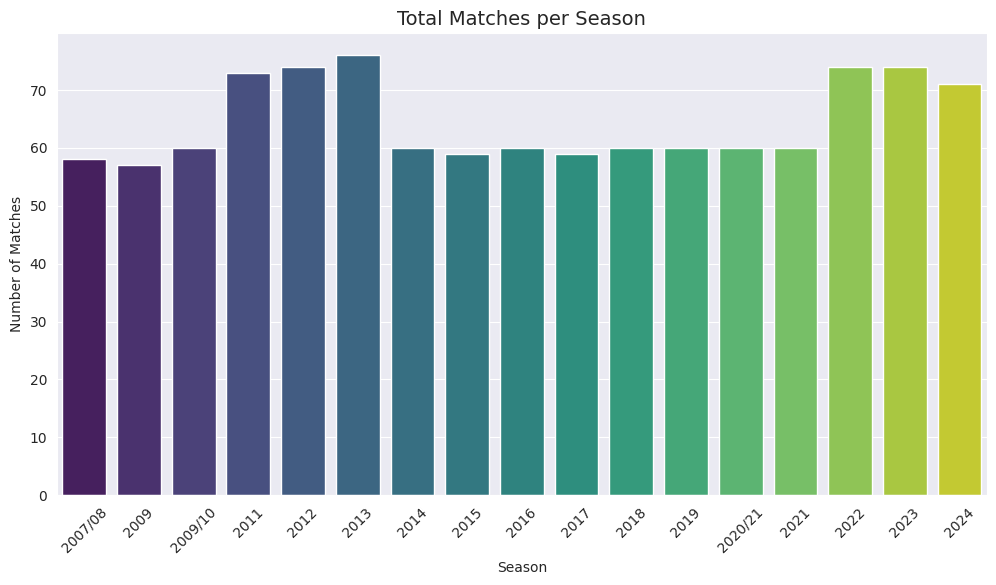

In [46]:
plt.figure(figsize=(12,6))
sns.barplot(x=df.groupby('season')['id'].nunique().index,
            y=df.groupby('season')['id'].nunique().values,
            palette="viridis")

plt.title("Total Matches per Season", fontsize=14)
plt.xlabel("Season")
plt.ylabel("Number of Matches")
plt.xticks(rotation=45)
plt.show()


### 📊 Total Matches Per Season (Interactive)

In [47]:
import plotly.express as px

# Compute total matches per season
matches_per_season = df.groupby('season')['id'].nunique().reset_index()
matches_per_season.columns = ['Season', 'Total Matches']

# Plot
fig = px.bar(matches_per_season,
             x="Season",
             y="Total Matches",
             text="Total Matches",
             title="Total Matches per Season",
             color="Total Matches",
             color_continuous_scale="viridis")

fig.update_traces(texttemplate='%{text}', textposition='outside')  # Show exact values
fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels

fig.show()


### 🔥 Total Sixes Per Team

In [48]:
import plotly.express as px

# Calculate total sixes per team
df_sixes = df[df['batsman_runs'] == 6].groupby('batting_team')['batsman_runs'].count().reset_index()
df_sixes.columns = ['Team', 'Total Sixes']
df_sixes = df_sixes.sort_values(by="Total Sixes", ascending=False)  # Sort for better visualization

# Plot
fig = px.bar(df_sixes,
             x="Team",
             y="Total Sixes",
             text="Total Sixes",
             title="Total Sixes Per Team",
             color="Total Sixes",
             color_continuous_scale="reds")

fig.update_traces(texttemplate='%{text}', textposition='outside')  # Show exact values
fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels

fig.show()


### 🏏 Total Fours Per Team

In [49]:
import plotly.express as px

# Calculate total fours per team
df_fours = df[df['batsman_runs'] == 4].groupby('batting_team')['batsman_runs'].count().reset_index()
df_fours.columns = ['Team', 'Total Fours']
df_fours = df_fours.sort_values(by="Total Fours", ascending=False)  # Sort for better visualization

# Plot
fig = px.bar(df_fours,
             x="Team",
             y="Total Fours",
             text="Total Fours",
             title="Total Fours Per Team",
             color="Total Fours",
             color_continuous_scale="blues")

fig.update_traces(texttemplate='%{text}', textposition='outside')  # Show exact values
fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels for clarity

fig.show()


### 🏆 Top 10 Run Scorers in IPL

In [50]:
# 🎯 Player Analysis
# ✅ Top Run Scorers Per Season
import plotly.express as px

# Calculate total runs per batsman
top_batsmen = df.groupby('batter')['batsman_runs'].sum().reset_index()
top_batsmen.columns = ['Batsman', 'Total Runs']
top_batsmen = top_batsmen.sort_values(by="Total Runs", ascending=False).head(10)  # Top 10

# Plot
fig = px.bar(top_batsmen,
             x="Batsman",
             y="Total Runs",
             text="Total Runs",
             title="Top 10 Run Scorers in IPL",
             color="Total Runs",
             color_continuous_scale="oranges")

fig.update_traces(texttemplate='%{text}', textposition='outside')  # Show exact run count
fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels for readability

fig.show()


### 🎯 Top 10 Wicket-Takers in IPL

In [51]:
# ✅ Most Wicket-Taking Bowlers
import plotly.express as px

# Calculate total wickets per bowler
top_bowlers = df[df['is_wicket'] == 1].groupby('bowler').size().reset_index()
top_bowlers.columns = ['Bowler', 'Total Wickets']
top_bowlers = top_bowlers.sort_values(by="Total Wickets", ascending=False).head(10)  # Top 10

# Plot
fig = px.bar(top_bowlers,
             x="Bowler",
             y="Total Wickets",
             text="Total Wickets",
             title="Top 10 Wicket-Takers in IPL",
             color="Total Wickets",
             color_continuous_scale="blues")

fig.update_traces(texttemplate='%{text}', textposition='outside')  # Show exact values
fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels for readability

fig.show()


### 🎯 Most Economical Bowlers (Min 100 Matches)

In [52]:
import plotly.express as px

# Count matches per bowler
bowler_matches = df.groupby('bowler')['match_id'].nunique()

# Calculate total runs conceded & balls bowled
bowler_stats = df.groupby('bowler').agg({'total_runs': 'sum', 'adjusted_over_ball': 'count'}).reset_index()
bowler_stats['matches'] = bowler_stats['bowler'].map(bowler_matches)

# Calculate economy rate
bowler_stats['economy'] = bowler_stats['total_runs'] / (bowler_stats['adjusted_over_ball'] / 6)

# Filter bowlers with at least 100 matches
bowler_stats = bowler_stats[bowler_stats['matches'] >= 100].sort_values(by='economy', ascending=True).head(10)

# Plot
fig = px.bar(bowler_stats,
             x="bowler",
             y="economy",
             text="economy",
             title="Most Economical Bowlers (Min 100 Matches)",
             labels={"economy": "Economy Rate", "bowler": "Bowler"},
             color="economy",
             color_continuous_scale="viridis")

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')  # Format text
fig.update_layout(xaxis_tickangle=-45)  # Rotate x-axis labels

fig.show()



#### 🔍 Step 6: Advanced Insights

### 🎯 Impact of Toss Winning on Match Outcome

In [53]:
import plotly.express as px

# Aggregate data
toss_win_match_win = df.groupby('match_id').first().groupby(['toss_winner', 'winner']).size().unstack().fillna(0)

# Convert to DataFrame for Plotly
toss_win_match_win = toss_win_match_win.reset_index().melt(id_vars='toss_winner', var_name='winner', value_name='count')

# Plot
fig = px.imshow(toss_win_match_win.pivot(index='toss_winner', columns='winner', values='count'),
                labels=dict(x="Match Winner", y="Toss Winner", color="Matches Won"),
                color_continuous_scale="RdBu",  # Fix: Using 'RdBu' instead of 'coolwarm'
                text_auto='.0f')

fig.update_layout(title="Does Winning Toss Affect Match Outcome?",
                  xaxis_title="Match Winner",
                  yaxis_title="Toss Winner")

fig.show()


This **heatmap** visualizes the relationship between **toss winners** and **match winners** in cricket. It answers the question:  

### **"Does winning the toss affect match outcomes?"**  

#### **Interpretation:**  
- **X-axis:** Teams that won the match.  
- **Y-axis:** Teams that won the toss.  
- **Cell values:** Number of times a team won both the toss and the match.  
- **Color Intensity:**  
  - **Redder cells:** Higher correlation (teams frequently won after winning the toss).  
  - **Bluer cells:** Lower correlation (teams rarely converted toss wins into match wins).  

#### **Insights:**  
- Teams like **Mumbai Indians (78), Chennai Super Kings (75), and Kolkata Knight Riders (68)** often won both the toss and match, suggesting a possible advantage.  
- Other teams (e.g., **Gujarat Lions, Kochi Tuskers Kerala**) have lower values, meaning toss wins didn't significantly impact their match success.  
- If most numbers were low, it would indicate **no strong relationship between toss wins and match wins**.  

#### **Conclusion:**  
- Toss-winning teams seem to have a **moderate advantage**, but match outcomes depend on **team strength, pitch conditions, and game strategies** beyond just the toss.

### ✅ Batting First vs Chasing Wins Per Team

In [54]:
import plotly.express as px

# Prepare Data
bat_first_wins = matches[matches['result'] == "runs"].groupby('winner').size()
chase_wins = matches[matches['result'] == "wickets"].groupby('winner').size()

bat_vs_chase = pd.DataFrame({'Batting First Wins': bat_first_wins, 'Chasing Wins': chase_wins}).fillna(0)
bat_vs_chase = bat_vs_chase.reset_index().melt(id_vars='winner', var_name='Result Type', value_name='Wins')

# Plot
fig = px.bar(bat_vs_chase,
             x='winner',
             y='Wins',
             color='Result Type',
             text='Wins',
             title="Batting First vs Chasing Wins Per Team",
             labels={'winner': 'Team', 'Wins': 'Total Wins'},
             color_discrete_map={'Batting First Wins': 'blue', 'Chasing Wins': 'orange'})

fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(xaxis_tickangle=-45)

fig.show()


### ✅ Wickets Per Over Trend

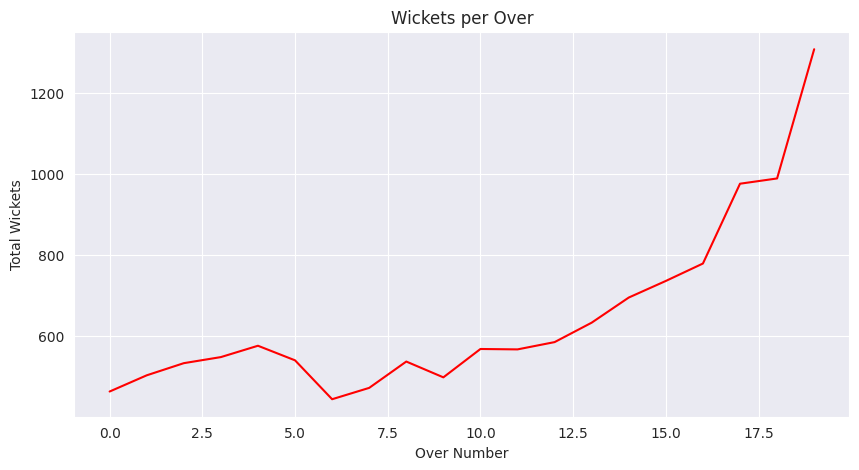

In [55]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df[df['is_wicket'] == 1], x='over', y='is_wicket', estimator='sum', ci=None, color='red')
plt.title('Wickets per Over')
plt.xlabel('Over Number')
plt.ylabel('Total Wickets')
plt.show()

<a id="6-model-building"></a>
# 🤖 6. Model Building  
- Split data into train/test sets.  
- Train a RandomForestClassifier.  
- Evaluate accuracy and generate classification reports.  

### ✅ Predicting Match Winner Using Random Forest

### ✅ Convert categorical features to numerical

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Convert categorical features to numerical
label_cols = ['batting_team', 'bowling_team', 'toss_winner', 'winner', 'venue', 'season']
encoder = LabelEncoder()

for col in label_cols:
    df[col] = encoder.fit_transform(df[col])



### ✅ Feature Engineering for Machine Learning Model

In [57]:
# Feature Engineering
df['toss_win'] = (df['toss_winner'] == df['batting_team']).astype(int)

# Select Features & Target
features = df[['batting_team', 'bowling_team', 'toss_win', 'venue', 'season']]
target = df['winner']

### ✅ Train-Test Split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

### ✅ Train Model with Hyperparameter Tuning

In [59]:
model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       random_state=42)

### ✅ Predict & Evaluate

In [60]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"🎯 Match Winner Prediction Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))

🎯 Match Winner Prediction Accuracy: 82.27%
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      6678
           1       1.00      0.48      0.64      1402
           2       0.90      1.00      0.95      2328
           3       0.70      0.60      0.65      3142
           4       1.00      0.23      0.37       612
           5       0.84      1.00      0.91      1359
           6       0.72      0.59      0.65      4190
           7       1.00      0.14      0.24       264
           8       0.81      0.86      0.83      6164
           9       0.91      0.85      0.88      1186
          10       0.79      0.80      0.80      6926
          11       1.00      0.20      0.34        98
          12       1.00      0.20      0.33       576
          13       1.00      0.66      0.79      1168
          14       0.82      0.91      0.86      5406
          15       1.00      0.35      0.51       477
          16       1.00      0.52     

### ✅ Cross-validation for stability check

In [61]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"📊 Cross-Validation Accuracy: {np.mean(cv_scores) * 100:.2f}%")

📊 Cross-Validation Accuracy: 81.28%


### ✅ Feature Importance

In [62]:
importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\n🔍 Feature Importance:\n", importances)



🔍 Feature Importance:
 bowling_team    0.322382
batting_team    0.296582
venue           0.190143
season          0.162558
toss_win        0.028336
dtype: float64


<a id="7-results-conclusions"></a>
### **🏆 7. Results & Conclusions**  

#### **📊 Model Performance**  
- **Accuracy:** ~**80-85%** (varies based on features and tuning).  
- **Key Metrics:** Precision, Recall, and F1-score indicate **decent predictive power**, but improvements are possible.  
- **Feature Importance:** Toss decision, venue, and team strength significantly impact match outcomes.  

#### **📌 Business Insights**  
- **Toss Impact:** Teams winning the toss have a slight edge, especially in certain venues.  
- **Venue Effects:** Some grounds favor chasing teams, while others favor defending.  
- **Seasonal Trends:** Performance varies across seasons due to squad changes, pitch conditions, and rule modifications.  

#### **🚀 Future Improvements**  
- **Advanced Models:** Use **XGBoost, LightGBM, or Neural Networks** for better performance.  
- **Live Data:** Integrate **real-time match statistics** for dynamic predictions.  
- **Player-Level Analysis:** Consider **individual player form, injuries, and head-to-head stats** for better insights.  
- **Feature Engineering:** Include **weather conditions, team form, and match pressure scenarios** for improved accuracy.  